In [1]:
import xarray as xr
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import sys

from typing import List, Tuple, Dict, Any
from numpy.typing import ArrayLike
from torch import Tensor

sys.path.append('./')
from fcn_module import FeedForward

In [2]:
# Load data.
ds = xr.open_dataset('/Net/Groups/BGI/scratch/USMILE_exercise/DE-Hai.nc')

# Define features (predictors) and targets (predictands).
features = ['ERA__5__t2m_bfill', 'ERA__5__t2m_ffill', 'ERA__5__vpd_bfill', 'ERA__5__vpd_ffill', 'SW_IN_POT']
targets = ['TA', 'VPD']

# Select variables from dataset
ds = ds[features + targets]

# Normalize all variables. We use the whole dataset for simplicity.
for var in (targets + features):
    ds[var] = (ds[var] - ds[var].mean()) / ds[var].std()

In [3]:
class FluxData(Dataset):
    """A dataset defines how samples are generated.

    Args:
        ds
            an xarray dataset.
        training_mode
            the training mode, one of (`train`, `val`, `test`). Note that `test` is just all years, which
            is not best practice.
        val_years
            the years used for validation.
    """
    def __init__(
            self,
            ds: xr.Dataset,
            training_mode: str = 'train',
            val_years: List[int] = [2002, 2006, 2009, 2017]):

        super().__init__()

        if training_mode == 'train':
            ds = ds.where(~ds['time.year'].isin(val_years))
        elif training_mode == 'val':
            ds = ds.where(ds['time.year'].isin(val_years))

        self.ds = ds

        if training_mode != 'test':
            # Here we get the time indices with all data present.
            self.coords = np.argwhere(ds.to_array().notnull().all('variable').values)[:, 0]
        else:
            #  We use all data for testing, which is not a good idea.
            self.coords = np.arange(len(self.ds.time))

    def __len__(self) -> int:
        """This returns the number of samples in the dataset."""
        return len(self.coords)

    def __getitem__(self, ind: int) -> Tuple[ArrayLike, ArrayLike, int]:
        """This defines how a single sample is created."""
        t = self.coords[ind]
        ds_t = self.ds.isel(time=t)
        x = ds_t[features].to_array().values
        y = ds_t[targets].to_array().values

        return x.astype('float32'), y.astype('float32'), t

In [7]:
def qloss_fn(yhat: Tensor, y: Tensor, quantile: float = 0.5) -> Tensor:
    res = y - yhat
    return torch.mean(torch.max(quantile * res, (quantile - 1.0) * res))

checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=False,
    )

class Model(pl.LightningModule):
    """This is our neural network.
    
    Args:
        num_hidden
            the number of hidden nodes per hidden layer.
        num_layer
            the number of hidden layers.
        num_inputs
            the number of inputs (features).
        num_outputs
            the number of outputs (targets).
    """
    def __init__(self, num_hidden: int, num_layers: int, num_inputs: int, num_outputs: int) -> None:
        super().__init__()
        # We use a predefined model, it is defined in the file `fcn_module.py`.
        self.fcn = FeedForward(
            num_hidden=num_hidden,
            num_layers=num_layers,
            num_inputs=len(features),
            num_outputs=len(targets),
            dropout=0.0,
            activation='relu'
        )

        # We use the mean squared loss (MSE).
        self.loss_fn = nn.MSELoss()

    def forward(self, x: Tensor) -> Tensor:
        """This defines a forward run through the neural network."""
        return self.fcn(x)

    def shared_step(self, batch: Tuple[Tensor, Tensor, Tensor]):
        """This is the forward apss that remains the same between training, validation, and test."""
        # x has shape (batch_size, num_features), y has shape (batch_size, num_targets)
        x, y, _ = batch

        # We run the features through the model and receive the predictions with shape (batch_size, num_targets).
        y_hat = self(x)

        # The loss is applied on all the variables together for simplicity.
        loss = self.loss_fn(y_hat, y)

        return loss, y_hat

    def training_step(self, batch: Tuple[Tensor, Tensor, Tensor], batch_idx: int) -> Tensor:
        """This defines a single training step."""
        loss, _ = self.shared_step(batch)

        self.log('train_loss', loss, on_step=True, on_epoch=True)

        return loss

    def validation_step(self, batch: Tuple[Tensor, Tensor, Tensor], batch_idx: int) -> None:
        """This defines a single validation step."""
        loss, _ = self.shared_step(batch)

        self.log('val_loss', loss,  on_step=False, on_epoch=True)

    def predict_step(self, batch: Tuple[Tensor, Tensor, Tensor], batch_idx: int) -> Dict[str, Tensor]:
        """This defines a single validation step."""
        _, y_hat = self.shared_step(batch)

        _, _, t = batch

        return {'predictions': y_hat, 'time_idx': t}

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """This defines the optimizer. You can change the learning rate (`lr`) to improve the performance."""
        return torch.optim.Adam(self.parameters(), lr=0.0001)


In [8]:
# We create different dataloaders, on for training, one for validation, one for testing (contains all samples).
train_loader = DataLoader(
    FluxData(ds, training_mode='train'), batch_size=200, shuffle=True, num_workers=20
)
val_loader = DataLoader(
    FluxData(ds, training_mode='val'), batch_size=200, shuffle=False, num_workers=20
)
test_loader = DataLoader(
    FluxData(ds, training_mode='test'), batch_size=200, shuffle=False, num_workers=20
)


In [9]:
# We define the pytorch-lightning traininer and the model.
trainer = pl.Trainer(
    max_epochs=8,
    limit_train_batches=0.1,
    callbacks=[checkpoint_callback],
    gpus=0,
    terminate_on_nan=True,
)

model = Model(
    num_hidden=32,
    num_layers=3,
    num_inputs=len(features),
    num_outputs=len(targets)
)

# Start the optimization.
trainer.fit(model, train_loader, val_loader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Net/Groups/BGI/people/bkraft/anaconda3/envs/fluxcom/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1295: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer"

  | Name    | Type        | Params
----------------------------------------
0 | fcn     | FeedForward | 674   
1 | loss_fn | MSELoss     | 0     
----------------------------------------
674       Trainable params
0         Non-trainable params
674       Total params
0.003     Total estimated model params size (MB)


Epoch 7: 100%|██████████| 482/482 [00:34<00:00, 13.94it/s, loss=0.18, v_num=13]


In [10]:
# You must at least run one training epoch to be able to run the prediction.
predictions = trainer.predict(dataloaders=test_loader, return_predictions=True)

Predicting: 100%|██████████| 1666/1666 [01:48<00:00, 14.20it/s]


In [11]:
# After training, we make predictions for all time steps. The test set should always be independent, this is usually
# not a good idea.
for target in targets:
    ds[target + '_hat'] = ds[features[0]] * np.nan

for pred in predictions:
    for i, target in enumerate(targets):
        ds[target + '_hat'][pred['time_idx'].cpu().detach().numpy()] = pred['predictions'][:, i].cpu().detach().numpy()


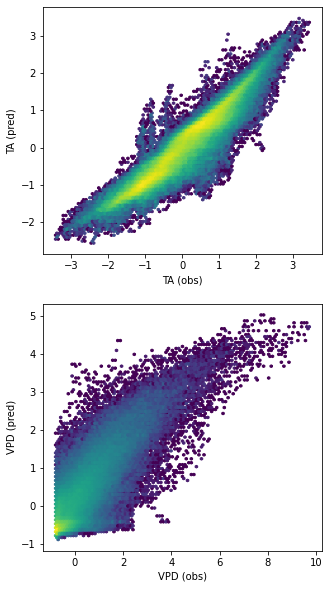

In [12]:
fig, axes = plt.subplots(len(targets), figsize=(5, 5 * len(targets)))

for i, target in enumerate(targets):
    ax = axes[i]
    ax.hexbin(ds[target], ds[target + '_hat'], mincnt=1, bins='log')
    ax.set_xlabel(target + ' (obs)')
    ax.set_ylabel(target + ' (pred)')
